# Baseline Text Classification


ACEInhibitors dataset from: https://www.dropbox.com/sh/ud5sf1fy6m7o219/AAD9pkY5gYe_XYV2oHDw68uva?dl=0

## Libraries and methods

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
path = "/content/gdrive/MyDrive/Magistrale/Stage/data"
root_dir = "/content/gdrive/MyDrive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#libraries
import csv
import numpy as np
import pandas as pd
import math
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import regexp_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from pathlib import Path  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#preprocessing methods 

def listToString(s): 
    str1 = "" 
    for ele in s: 
        str1 = str1 + " " + ele
    return str1

def clean_text(df, col):
    """A function for keeping only alpha-numeric characters and replacing all 
    white space with a single space.
    """

    #[^A-Za-z0-9]+: regex to match a string of characters that are not a letters or numbers
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', str(x).lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

def count_words(df, column):
    df = df.copy()

    # df['n_questionmarks'] = count_pattern(df, text, '\?')
    # df['n_periods'] = count_pattern(df, text, '\.')
    # df['n_apostrophes'] = count_pattern(df, text, '\'')
    # df['first_word'] = df[text_clean].apply(lambda x: split_on_word(x)[0])
    # question_words = ['what', 'how', 'why', 'is']
    # for w in question_words:
    #     col_wc = 'n_' + w
    #     col_fw = 'fw_' + w
    #     df[col_wc] = count_pattern(df, text_clean, w)
    #     df[col_fw] = (df.first_word == w) * 1
        
    # del df['first_word']
    
    col_name = "n_words_in_" + column
    df[col_name] = df[column].apply(lambda x: len(split_on_word(x)))

    return df

def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*") for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

In [5]:
def from_list_values_to_columns(col, k, print=False): 

#obtaining the unique values 

  dataset[k][col] = dataset[k][col].apply(eval)

  col_dict = {} 
  for i in dataset[k][col]: #obtain value_count in a dictionary
    for j in i:
        if j not in col_dict:
            col_dict[j] = 1 #new column
        else:
            col_dict[j] += 1 #update column count

  series = pd.Series([x for _list in dataset[k][col] for x in _list]) #reducing its dimensions from 2 to 1 

  if print == True:
    print(series.value_counts()) #display value count

#creating new binary columns 

  bool_dict = {} #create boolean dict (the binary value for every colum in col_dict and for every row in the dataset[k])
  for i, item in enumerate(col_dict.keys()): 
    bool_dict[item] = dataset[k][col].apply(lambda x: item in x)

  return pd.DataFrame(bool_dict).astype(int)

In [6]:
def update_col_names(feature, df, sub_features): 

  #useful trasnformation for assigning a list to a dataframe cell
  l = col_names.index[col_names["feature"] == feature].tolist()
  col_names.at[l[0], df] = sub_features

In [7]:
def find_documents_about_topic(df, column, new_column, l): 

  x = df[column][df[column].str.contains('|'.join(l))] #rows in df[column] that contains at least 1 item of "words"
  
  df[new_column] = 0
  df.loc[df.index.isin(x.index), new_column] = 1 #assigning 1 to the corresponding rows of x in df

  print("Number of documents that", new_column, ":", len(x))

  return df

In [8]:
def evalmetrics(y_test, test_predicted, labels, new_row, res): 

  #f-2 score
  f2 = fbeta_score(y_test, test_predicted, average='binary', beta=2)
  print("\nF-2 score with dataset", new_row["df"], ":", f2, "\n")

  #f-3 score
  f3 = fbeta_score(y_test, test_predicted, average='binary', beta=3)
  print("F-3 score with dataset", new_row["df"], ":", f3, "\n")

  #confusion matrix
  cm = confusion_matrix(y_test, test_predicted, labels=labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  title = new_row["model"] + " confusion matrix on dataset " + new_row["df"]
  disp.ax_.set_title(title)

  #evaluation metrics
  report = classification_report(y_test, test_predicted, output_dict=True)
  display(pd.DataFrame(report).transpose().round(decimals=3))

  new_row.update({'f2_score' : f2, 'f3_score' : f3})
  res = res.append(new_row, ignore_index=True)

  return res

In [9]:
def compute_fbeta_avg(res): 

  for i in res["df"].unique(): 
    for j in res["model"].unique(): 
      condition = (res["df"] == i) & (res["model"] == j)

      #computing f2 mean score
      res.loc[condition, 'f2_avg'] = res["f2_score"].where(condition).mean()

      #computing f3 mean score
      res.loc[condition, 'f3_avg'] = res["f3_score"].where(condition).mean()

  return res

## Import of data

In [10]:
dataset = dict()

### ACE Inhibitors dataset

In [11]:
#import of data
from_drive = True

if from_drive == True: 
  dataset["ace"] = pd.read_csv(path + "/ACEInhibitors.tsv", sep='\t')
else: 
  dataset["ace"] = pd.read_csv('/content/ACEInhibitors.tsv', sep='\t')

In [12]:
print(dataset["ace"].shape)
pd.set_option('display.max_columns', None)
display(dataset["ace"].head(3))

(2544, 53)


,PMID,OWN,STAT,DCOM,LR,IS,VI,IP,DP,Title,PG,Abstract,FAU,AU,AD,LA,PT,PL,TA,JT,JID,RN,SB,MH,EDAT,MHDA,CRDT,PHST,AID,PST,SO,GR,CIN,EIN,RF,CI,PMC,CON,OTO,OT,IR,FIR,IRAD,CRI,LID,CN,TT,OID,SPIN,DEP,ORI,RIN,Label
0,10024335,NLM,MEDLINE,19990309,20190722,0194-911X (Print) 0194-911X (Linking),33,2,1999 Feb,Distinct and combined vascular effects of ACE ...,719-25,Hypercholesterolemia and hypertension are freq...,"['Nazzaro, P', 'Manzari, M', 'Merlo, M', 'Trig...","['Nazzaro P', 'Manzari M', 'Merlo M', 'Triggia...",['Department of Clinical Methodology and Medic...,['eng'],"['Clinical Trial', 'Controlled Clinical Trial'...",United States,Hypertension,"Hypertension (Dallas, Tex. : 1979)",7906255,['0 (Angiotensin-Converting Enzyme Inhibitors)...,IM,"['Adult', 'Angiotensin-Converting Enzyme Inhib...",1999/02/19 00:00,1999/02/19 00:01,['1999/02/19 00:00'],"['1999/02/19 00:00 [pubmed]', '1999/02/19 00:0...",['10.1161/01.hyp.33.2.719 [doi]'],ppublish,Hypertension. 1999 Feb;33(2):719-25. doi: 10.1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10027665,NLM,MEDLINE,19990506,20190813,0031-6970 (Print) 0031-6970 (Linking),54,11,1999 Jan,Computerized surveillance of adverse drug reac...,887-92,OBJECTIVE: To implement and measure the effect...,"['Levy, M', 'Azaz-Livshits, T', 'Sadan, B', 'S...","['Levy M', 'Azaz-Livshits T', 'Sadan B', 'Shal...","['Department of Medicine, Hadassah University ...",['eng'],"['Journal Article', ""Research Support, Non-U.S...",Germany,Eur J Clin Pharmacol,European journal of clinical pharmacology,1256165,NaN,IM,['Adverse Drug Reaction Reporting Systems/econ...,1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...",['10.1007/s002280050571 [doi]'],ppublish,Eur J Clin Pharmacol. 1999 Jan;54(11):887-92. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10027935,NLM,MEDLINE,19990416,20161124,0085-2538 (Print) 0085-2538 (Linking),55,3,1999 Mar,Glomerular size-selective dysfunction in NIDDM...,984-94,BACKGROUND: In patients with insulin-dependent...,"['Ruggenenti, P', 'Mosconi, L', 'Sangalli, F',...","['Ruggenenti P', 'Mosconi L', 'Sangalli F', 'C...","['Department of Kidney Research, Mario Negri I...",['eng'],"['Clinical Trial', 'Journal Article', 'Randomi...",United States,Kidney Int,Kidney international,0323470,['0 (Angiotensin-Converting Enzyme Inhibitors)...,IM,"['Adult', 'Aged', 'Angiotensin-Converting Enzy...",1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...","['10.1046/j.1523-1755.1999.055003984.x [doi]',...",ppublish,Kidney Int. 1999 Mar;55(3):984-94. doi: 10.104...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Columns distribution

In [13]:
print(dataset["ace"].columns)

Index(['PMID', 'OWN', 'STAT', 'DCOM', 'LR', 'IS', 'VI', 'IP', 'DP', 'Title',
       'PG', 'Abstract', 'FAU', 'AU', 'AD', 'LA', 'PT', 'PL', 'TA', 'JT',
       'JID', 'RN', 'SB', 'MH', 'EDAT', 'MHDA', 'CRDT', 'PHST', 'AID', 'PST',
       'SO', 'GR', 'CIN', 'EIN', 'RF', 'CI', 'PMC', 'CON', 'OTO', 'OT', 'IR',
       'FIR', 'IRAD', 'CRI', 'LID', 'CN', 'TT', 'OID', 'SPIN', 'DEP', 'ORI',
       'RIN', 'Label'],
      dtype='object')


In [14]:
dataset["ace"].rename(columns={"MH" : "mesh_terms"}, inplace=True)
dataset["ace"]["mesh_terms"].value_counts()

['Adult', 'Angiotensin-Converting Enzyme Inhibitors/*administration & dosage', 'Cardiovascular System/drug effects', 'Drug Interactions', 'Enalapril/*administration & dosage', 'Humans', 'Hydroxymethylglutaryl-CoA Reductase Inhibitors/*administration & dosage', 'Hypercholesterolemia/*complications/*drug therapy', 'Hypertension/*complications/*drug therapy', 'Male', 'Simvastatin/*administration & dosage']                                                                                                                                                                                                                                                                                   1
['Aged', 'Aged, 80 and over', 'Antihypertensive Agents/adverse effects/*therapeutic use', 'Blood Pressure/drug effects/physiology', 'Female', 'Humans', 'Hypertension/*drug therapy/physiopathology', 'Male', 'Prospective Studies', 'Sweden']                                                                               

In [15]:
dataset["ace"].rename(columns={"STAT" : "status"}, inplace=True)
dataset["ace"]["status"].value_counts()

MEDLINE               2539
PubMed-not-MEDLINE       5
Name: status, dtype: int64

Useless

In [16]:
dataset["ace"].rename(columns={"VI" : "volume_number"}, inplace=True)
dataset["ace"]["volume_number"].value_counts()

15              68
14              65
12              62
13              61
16              59
                ..
290              1
107 Suppl 5      1
146              1
63 Spec No 1     1
339              1
Name: volume_number, Length: 243, dtype: int64

In [17]:
dataset["ace"].rename(columns={"IP" : "issue"}, inplace=True)
dataset["ace"]["issue"].value_counts()

3       314
1       311
2       301
5       250
4       239
       ... 
9153      1
42        1
44        1
9268      1
9145      1
Name: issue, Length: 147, dtype: int64

VI and IP both contain non numeric values.

In [18]:
dataset["ace"].rename(columns={"DP" : "publication_date"}, inplace=True)

print(dataset["ace"]["publication_date"].value_counts())

1994           33
2000 Dec       29
2001 Feb       26
2001 Dec       26
2001 Mar       25
               ..
2002 Nov 20     1
2002 Nov 15     1
2002 Oct 14     1
2002 Sep 7      1
1998 Nov 30     1
Name: publication_date, Length: 565, dtype: int64


In [19]:
dataset["ace"].rename(columns={"FAU" : "full_authors"}, inplace=True)
dataset["ace"]["full_authors"].value_counts()

['Kaplan, N M']                                                       4
['Cohen, J S']                                                        4
['Deedwania, P C']                                                    3
['Vidt, D G']                                                         3
['Pitt, B']                                                           3
                                                                     ..
['Carter, J D', 'Valeriano-Marcet, J', 'Kanik, K S', 'Vasey, F B']    1
['Bomann, J Scott', 'Peckler, Bradley F']                             1
['Coppo, R', 'Chiesa, M', 'Peruzzi, L', 'Amore, A']                   1
['Nyawo, B', 'Sarkar, P']                                             1
['Trautmann, A', 'Klein, C E', 'Kampgen, E', 'Brocker, E B']          1
Name: full_authors, Length: 2452, dtype: int64

In [20]:
dataset["ace"].rename(columns={"AU" : "authors"}, inplace=True)
dataset["ace"]["authors"].value_counts()

['Vidt DG']                                                    4
['Cohen JS']                                                   4
['Kaplan NM']                                                  4
['Weir MR']                                                    3
['Kjoller-Hansen L', 'Steffensen R', 'Grande P']               3
                                                              ..
['Cai X', 'Shen W', 'Gong L']                                  1
['Carter JD', 'Valeriano-Marcet J', 'Kanik KS', 'Vasey FB']    1
['Bomann JS', 'Peckler BF']                                    1
['Coppo R', 'Chiesa M', 'Peruzzi L', 'Amore A']                1
['Trautmann A', 'Klein CE', 'Kampgen E', 'Brocker EB']         1
Name: authors, Length: 2442, dtype: int64

Similar to FAU, but FAU contains more values.

I'm maintaining FAU over FA.

In [21]:
dataset["ace"].rename(columns={"AD" : "affiliation"}, inplace=True)
dataset["ace"]["affiliation"].value_counts()

['Department of Internal Medicine and Therapeutics, University of Pavia, Italy.']                                                                                         10
['Adis International Limited, Auckland, New Zealand.']                                                                                                                     9
['Adis International Limited, Auckland, New Zealand. demail@adis.co.nz']                                                                                                   8
['Department of Pharmacokinetics and Drug Metabolism, Boehringer Ingelheim Pharma KG, Birkendorfer Strasse, D-88397 Biberach an der Riss, Germany.']                       6
['Adis International Limited, Mairangi Bay, Auckland, New Zealand. demail@adis.co.nz']                                                                                     6
                                                                                                                                       

The names are not standardized, not useful without preprocessing.

In [22]:
dataset["ace"].rename(columns={"LA" : "language"}, inplace=True)
dataset["ace"]["language"].value_counts()

['eng']           2513
['fre']              7
['pol']              7
['eng', 'por']       4
['spa']              3
['dan']              2
['ger']              1
['eng', 'fre']       1
['eng', 'ita']       1
['rus']              1
['hrv']              1
['jpn']              1
['nor']              1
['ita']              1
Name: language, dtype: int64

Most of them are in english, so probably it's not useful.

In [23]:
dataset["ace"].rename(columns={"PT" : "publication_type"}, inplace=True)
dataset["ace"]["publication_type"].value_counts()

['Journal Article', 'Review']                                                                                                         284
['Clinical Trial', 'Journal Article', 'Randomized Controlled Trial']                                                                  233
['Clinical Trial', 'Journal Article', 'Randomized Controlled Trial', "Research Support, Non-U.S. Gov't"]                              231
['Clinical Trial', 'Comparative Study', 'Journal Article', 'Randomized Controlled Trial', "Research Support, Non-U.S. Gov't"]         186
['Clinical Trial', 'Comparative Study', 'Journal Article', 'Randomized Controlled Trial']                                             170
                                                                                                                                     ... 
['Clinical Trial', 'Comparative Study', 'Evaluation Study', 'Journal Article', 'Multicenter Study', 'Randomized Controlled Trial']      1
['Journal Article', "Research Supp

In [24]:
dataset["ace"].rename(columns={"PL" : "publication_place"}, inplace=True)
dataset["ace"]["publication_place"].value_counts()

United States                1253
England                       786
Germany                        92
New Zealand                    83
Switzerland                    80
Netherlands                    42
India                          26
Italy                          23
Australia                      22
Sweden                         20
France                         18
Japan                          15
China                          14
Canada                         11
Poland                          8
Denmark                         8
South Africa                    5
Thailand                        5
Brazil                          4
Ireland                         4
Austria                         4
Spain                           3
Hungary                         2
Greece                          1
Norway                          1
China (Republic : 1949- )       1
Portugal                        1
Israel                          1
Zimbabwe                        1
Scotland      

In [25]:
dataset["ace"]["publication_place"].value_counts().index

Index(['United States', 'England', 'Germany', 'New Zealand', 'Switzerland',
       'Netherlands', 'India', 'Italy', 'Australia', 'Sweden', 'France',
       'Japan', 'China', 'Canada', 'Poland', 'Denmark', 'South Africa',
       'Thailand', 'Brazil', 'Ireland', 'Austria', 'Spain', 'Hungary',
       'Greece', 'Norway', 'China (Republic : 1949- )', 'Portugal', 'Israel',
       'Zimbabwe', 'Scotland', 'Singapore', 'Korea (South)', 'Saudi Arabia',
       'Croatia', 'Argentina', 'Belgium', 'Russia (Federation)', 'Mexico',
       'Nigeria'],
      dtype='object')

In [26]:
dataset["ace"].rename(columns={"TA" : "journal_title_abbreviation"}, inplace=True)
dataset["ace"]["journal_title_abbreviation"].value_counts()

Am J Hypertens                115
J Hum Hypertens               114
Am J Cardiol                   99
Circulation                    86
J Hypertens                    83
                             ... 
Anticancer Drugs                1
J R Soc Promot Health           1
Int J Geriatr Psychiatry        1
Eur J Nucl Med Mol Imaging      1
J Card Surg                     1
Name: journal_title_abbreviation, Length: 393, dtype: int64

In [27]:
dataset["ace"].rename(columns={"JT" : "journal_title"}, inplace=True)
dataset["ace"]["journal_title"].value_counts()

American journal of hypertension                                115
Journal of human hypertension                                   114
The American journal of cardiology                               99
Circulation                                                      86
Journal of hypertension                                          83
                                                               ... 
Anti-cancer drugs                                                 1
The journal of the Royal Society for the Promotion of Health      1
International journal of geriatric psychiatry                     1
European journal of nuclear medicine and molecular imaging        1
Journal of cardiac surgery                                        1
Name: journal_title, Length: 393, dtype: int64

JT are the same as TA but without approximations.

I'm maintaining the compact version.

In [28]:
dataset["ace"]["Label"].value_counts()

0    2503
1      41
Name: Label, dtype: int64

#### Columns selection

In [29]:
dataset["ace"] = dataset["ace"][["publication_date", "full_authors", "publication_type", "publication_place", "journal_title_abbreviation", "Title", "Abstract", "mesh_terms", "Label"]]

### Chronic obstructive pulmonary disease (COPD) dataset

In [30]:
#import of copd dataset
from_drive = True

if from_drive == True: 
  dataset["copd"] = pd.read_csv(path + "/copd.tsv", sep='\t')
else: 
  dataset["copd"] = pd.read_csv('/content/copd.tsv', sep='\t')

In [31]:
print(dataset["copd"].shape)
display(dataset["copd"].head(3))

(1606, 3)


,Label,Title,Abstract
0,0,the soluble form of a disintegrin and metallop...,the soluble form of a disintegrin and metallop...
1,1,interactive effect of paraoxonase-1 q192r poly...,interactive effect of paraoxonase-1 q192r poly...
2,0,trx-ask1-jnk signaling regulation of cell dens...,trx-ask1-jnk signaling regulation of cell dens...


In [32]:
dataset["copd"]["Label"].value_counts()

0    1410
1     196
Name: Label, dtype: int64

### Proton Pump Inhibitors dataset

In [33]:
#import of ppi dataset
from_drive = True

if from_drive == True: 
  dataset["ppi"] = pd.read_csv(path + "/ProtonPumpInhibitors.tsv", sep='\t')
else: 
  dataset["ppi"] = pd.read_csv('/content/ProtonPumpInhibitors.tsv', sep='\t')

In [34]:
print(dataset["ppi"].shape)
display(dataset["ppi"].head(3))

(1333, 48)


,PMID,OWN,STAT,DCOM,LR,IS,VI,IP,DP,Title,PG,Abstract,FAU,AU,AD,LA,GR,PT,PL,TA,JT,JID,RN,SB,MH,PMC,EDAT,MHDA,CRDT,PHST,AID,PST,SO,RF,EIN,CON,CIN,CI,CN,MID,TT,DEP,OID,OTO,OT,GN,UIN,Label
0,10024259,NLM,MEDLINE,19990324,20190504,0959-8138 (Print) 0959-8138 (Linking),318,7182,1999 Feb 20,Symptomatic gastro-oesophageal reflux disease:...,502-7,OBJECTIVE: To assess intermittent treatment ov...,"['Bardhan, K D', 'Muller-Lissner, S', 'Bigard,...","['Bardhan KD', 'Muller-Lissner S', 'Bigard MA'...","['Rotherham General Hospitals NHS Trust, Rothe...",['eng'],['Wellcome Trust/United Kingdom'],"['Clinical Trial', 'Comparative Study', 'Journ...",England,BMJ,BMJ (Clinical research ed.),8900488,"['0 (Anti-Ulcer Agents)', '884KT10YB7 (Ranitid...",AIM IM,"['Adult', 'Aged', 'Anti-Ulcer Agents/*therapeu...",PMC27748,1999/02/19 00:00,1999/02/19 00:01,['1999/02/19 00:00'],"['1999/02/19 00:00 [pubmed]', '1999/02/19 00:0...",['10.1136/bmj.318.7182.502 [doi]'],ppublish,BMJ. 1999 Feb 20;318(7182):502-7. doi: 10.1136...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10027653,NLM,MEDLINE,19990506,20190813,0031-6970 (Print) 0031-6970 (Linking),54,11,1999 Jan,Helicobacter pylori clearance and serum gastri...,817-20,OBJECTIVE: To determine which demographic fact...,"['Lee, C T', 'Kuo, B I', 'Chen, C Y', 'Chang, ...","['Lee CT', 'Kuo BI', 'Chen CY', 'Chang FY', 'L...","['Department of Medicine, Veterans General Hos...",['eng'],NaN,"['Clinical Trial', 'Journal Article']",Germany,Eur J Clin Pharmacol,European journal of clinical pharmacology,1256165,"['0 (Gastrins)', '9001-10-9 (Pepsinogen A)', '...",IM,"['Adult', 'Age Factors', 'Aged', 'Duodenal Ulc...",NaN,1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...",['10.1007/s002280050559 [doi]'],ppublish,Eur J Clin Pharmacol. 1999 Jan;54(11):817-20. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10029360,NLM,MEDLINE,19990421,20191102,1102-416X (Print) 1102-416X (Linking),NaN,582,1998,Antimicrobial treatment of H. pylori infection...,16-26,OBJECTIVE: To evaluate the clinical efficacy o...,"['Unge, P']",['Unge P'],"['Department of Medicine, Lanssjukhuset Gavle ...",['eng'],NaN,"['Journal Article', 'Meta-Analysis']",England,Eur J Surg Suppl,The European journal of surgery. Supplement. :...,9114489,"['0 (Antacids)', '0 (Anti-Bacterial Agents)', ...",IM,"['Antacids/therapeutic use', 'Anti-Bacterial A...",NaN,1999/02/24 00:00,1999/02/24 00:01,['1999/02/24 00:00'],"['1999/02/24 00:00 [pubmed]', '1999/02/24 00:0...",['10.1080/11024159850191391 [doi]'],ppublish,Eur J Surg Suppl. 1998;(582):16-26. doi: 10.10...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Columns distribution

In [35]:
print(dataset["ppi"].columns)

Index(['PMID', 'OWN', 'STAT', 'DCOM', 'LR', 'IS', 'VI', 'IP', 'DP', 'Title',
       'PG', 'Abstract', 'FAU', 'AU', 'AD', 'LA', 'GR', 'PT', 'PL', 'TA', 'JT',
       'JID', 'RN', 'SB', 'MH', 'PMC', 'EDAT', 'MHDA', 'CRDT', 'PHST', 'AID',
       'PST', 'SO', 'RF', 'EIN', 'CON', 'CIN', 'CI', 'CN', 'MID', 'TT', 'DEP',
       'OID', 'OTO', 'OT', 'GN', 'UIN', 'Label'],
      dtype='object')


In [36]:
dataset["ppi"].rename(columns={"MH" : "mesh_terms"}, inplace=True)
dataset["ppi"]["mesh_terms"].value_counts()

['Adult', 'Aged', 'Anti-Ulcer Agents/*therapeutic use', 'Double-Blind Method', 'Female', 'Gastroesophageal Reflux/*drug therapy', 'Humans', 'Male', 'Middle Aged', 'Omeprazole/*therapeutic use', 'Ranitidine/*therapeutic use', 'Time Factors', 'Treatment Outcome']                                                                                                                                                                                                            1
['2-Pyridinylmethylsulfinylbenzimidazoles', 'Adult', 'Aged', 'Anti-Ulcer Agents/adverse effects/therapeutic use', 'Clinical Trials as Topic', 'Female', 'Gastric Acid/metabolism', 'Humans', 'Lansoprazole', 'Male', 'Middle Aged', 'Omeprazole/adverse effects/*analogs & derivatives/therapeutic use', 'Proton Pump Inhibitors', 'Zollinger-Ellison Syndrome/*drug therapy']                                                                                                   1
['Animals', 'Anti-Inflammatory Agents, Non-Steroidal/adverse effec

In [37]:
dataset["ppi"].rename(columns={"STAT" : "status"}, inplace=True)
dataset["ppi"]["status"].value_counts()

MEDLINE               1330
PubMed-not-MEDLINE       3
Name: status, dtype: int64

Useless

In [38]:
dataset["ppi"].rename(columns={"DP" : "publication_date"}, inplace=True)

print(dataset["ppi"]["publication_date"].value_counts())

1999 Aug        20
2000 Oct        19
2000 Mar        19
2000 Dec        18
1996 Aug        18
                ..
2003 Jan-Feb     1
2003 Mar 1       1
2003 Mar 29      1
2003 May 1       1
1998 Sep-Oct     1
Name: publication_date, Length: 276, dtype: int64


In [39]:
dataset["ppi"].rename(columns={"FAU" : "full_authors"}, inplace=True)
dataset["ppi"]["full_authors"].value_counts()

['Kahrilas, P J']                                                                                           4
['Dekkers, C P', 'Beker, J A', 'Thjodleifsson, B', 'Gabryelewicz, A', 'Bell, N E', 'Humphries, T J']        3
['de Boer, W A', 'Tytgat, G N']                                                                             3
['DeVault, K R']                                                                                            3
['Rosch, T']                                                                                                2
                                                                                                           ..
['Galmiche, J P', 'Zerbib, F', 'Ducrotte, P', 'Fournet, J', 'Rampal, P', 'Avasthy, N', 'Humphries, T J']    1
['Sharma, P']                                                                                               1
['Caro, J J', 'Salas, M', 'Ward, A']                                                                        1
['Fennerty

In [40]:
dataset["ppi"].rename(columns={"AD" : "affiliation"}, inplace=True)
dataset["ppi"]["affiliation"].value_counts()

['Adis International Limited, Auckland, New Zealand. demail@adis.co.nz']                                                                               5
['Department of Gastroenterology, Free University Hospital, Amsterdam, The Netherlands.']                                                              4
['Third Department of Internal Medicine, Hokkaido University School of Medicine, Sapporo, Japan.']                                                     4
['Adis International Limited, Auckland, New Zealand.']                                                                                                 3
['Department of Internal Medicine, Sint Anna Hospital, Oss, The Netherlands.']                                                                         3
                                                                                                                                                      ..
['Unit for Applied Clinical Research, Norwegian University of Science and Technolo

The names are not standardized, not useful without preprocessing.

In [41]:
dataset["ppi"].rename(columns={"LA" : "language"}, inplace=True)
dataset["ppi"]["language"].value_counts()

['eng']           1300
['eng', 'spa']       9
['spa']              7
['ger']              7
['jpn']              3
['por']              2
['pol']              1
['rus']              1
['hrv']              1
['dut']              1
['fre']              1
Name: language, dtype: int64

Most of them are in english, so probably it's not useful.

In [42]:
dataset["ppi"].rename(columns={"PT" : "publication_type"}, inplace=True)
dataset["ppi"]["publication_type"].value_counts()

['Journal Article', 'Review']                                                                                                         202
['Clinical Trial', 'Journal Article', 'Randomized Controlled Trial', "Research Support, Non-U.S. Gov't"]                              118
['Clinical Trial', 'Journal Article', 'Randomized Controlled Trial']                                                                   89
['Clinical Trial', 'Comparative Study', 'Journal Article', 'Randomized Controlled Trial']                                              88
['Journal Article']                                                                                                                    79
                                                                                                                                     ... 
['Comparative Study', 'Journal Article', "Research Support, Non-U.S. Gov't", "Research Support, U.S. Gov't, Non-P.H.S.", 'Review']      1
['Comparative Study', 'English Abs

In [43]:
dataset["ppi"].rename(columns={"PL" : "publication_place"}, inplace=True)
dataset["ppi"]["publication_place"].value_counts()

England                      606
United States                455
Switzerland                   40
Germany                       38
New Zealand                   32
Canada                        26
Greece                        22
Japan                         21
Spain                         14
India                         11
Singapore                     10
Australia                      8
Netherlands                    6
France                         5
Italy                          5
Croatia                        3
United Arab Emirates           3
Brazil                         3
Korea (South)                  2
Ireland                        2
China (Republic : 1949- )      2
Kenya                          1
Northern Ireland               1
Israel                         1
Pakistan                       1
Peru                           1
Hungary                        1
Bosnia and Herzegovina         1
Denmark                        1
Poland                         1
Russia (Fe

In [44]:
dataset["ppi"].rename(columns={"TA" : "journal_title_abbreviation"}, inplace=True)
dataset["ppi"]["journal_title_abbreviation"].value_counts()

Aliment Pharmacol Ther             282
Am J Gastroenterol                 137
Eur J Gastroenterol Hepatol         61
Scand J Gastroenterol               55
Gut                                 44
                                  ... 
Zhonghua Yi Xue Za Zhi (Taipei)      1
Nat Rev Drug Discov                  1
BMC Gastroenterol                    1
J Postgrad Med                       1
Clin Nucl Med                        1
Name: journal_title_abbreviation, Length: 218, dtype: int64

In [45]:
dataset["ppi"]["Label"].value_counts()

0    1282
1      51
Name: Label, dtype: int64

#### Columns selection

In [46]:
dataset["ppi"] = dataset["ppi"][["publication_date", "full_authors", "publication_type", "publication_place", "journal_title_abbreviation", "Title", "Abstract", "mesh_terms", "Label"]]

## Columns preprocessing

### Text preprocessig

- Checking missing values, 
- Concatenating `Title`, `Abstract` and `mesh_terms` in `text`,
- Preprocessing the text in `text_clean`,
- Removing missing values.

In [47]:
## Variable mesh_terms

for i in dataset: 

  if i != "copd": 

    #replace missing values with empty list
    dataset[i]["mesh_terms"] = dataset[i]["mesh_terms"].replace(np.NaN, "[]")

    #from list of strings to string
    for index, value in enumerate(dataset[i]["mesh_terms"]): 
      dataset[i].loc[index, "mesh_terms"] = listToString(eval(value))
      
    dataset[i]['mesh_terms'] = dataset[i]['mesh_terms'].str.replace('[/*]',' ')
    dataset[i] = count_words(dataset[i], "mesh_terms")

In [48]:
## Variables Title ad Abstract

for i in dataset: 
  #count number of words in Title
  dataset[i] = count_words(dataset[i], "Title")

  #count number of words in Abstract
  dataset[i]["Abstract"] = dataset[i]["Abstract"].replace(np.NaN, "[]") #replace missing values with empty list
  dataset[i]["Abstract"] = dataset[i]["Abstract"].astype(str) 
  dataset[i] = count_words(dataset[i], "Abstract")

In [49]:
for i in dataset: 

  #checking missing values
  print("Dataset", i, "shape:", dataset[i].shape)
  print(dataset[i].isnull().sum(axis=0), "\n")

  #concatenating Title, Abstract (and mesh_terms)
  if i != "copd": 
    dataset[i]['text'] = dataset[i]['Title'] + (dataset[i]['Abstract']).fillna(' ') + (dataset[i]['mesh_terms']).fillna(' ')
    dataset[i].drop(['Title', "Abstract", "mesh_terms"], inplace=True, axis=1)
  else:
    dataset[i]['text'] = dataset[i]['Title'] + (dataset[i]['Abstract']).fillna(' ')
    dataset[i].drop(['Title', "Abstract"], inplace=True, axis=1)
    
  ## Variable text_clean

  #text preprocessing
  dataset[i]['text_clean'] = clean_text(dataset[i], 'text')

  #removing Nan and checking missing values again
  print("Missing values after creating \"text\":")
  print(dataset[i].isnull().sum(axis=0))
  dataset[i] = dataset[i].dropna()
  dataset[i] = dataset[i].reset_index()
  print("New dataset shape:", dataset[i].shape, "\n")


Dataset ace shape: (2544, 12)
publication_date               0
full_authors                  48
publication_type               0
publication_place              0
journal_title_abbreviation     0
Title                          0
Abstract                       0
mesh_terms                     0
Label                          0
n_words_in_mesh_terms          0
n_words_in_Title               0
n_words_in_Abstract            0
dtype: int64 

Missing values after creating "text":
publication_date               0
full_authors                  48
publication_type               0
publication_place              0
journal_title_abbreviation     0
Label                          0
n_words_in_mesh_terms          0
n_words_in_Title               0
n_words_in_Abstract            0
text                           0
text_clean                     0
dtype: int64
New dataset shape: (2496, 12) 

Dataset copd shape: (1606, 5)
Label                  0
Title                  0
Abstract               0
n_words_

### Features preprocessing

In [50]:
#creating col_names (used to store columns' names)
col_names = pd.DataFrame(columns = ["feature", "ace", "ppi"])
col_names = col_names.append({"feature": "publication_type"}, ignore_index = True)
col_names = col_names.append({"feature": "full_authors"}, ignore_index = True)
display(col_names)

,feature,ace,ppi
0,publication_type,NaN,NaN
1,full_authors,NaN,NaN


In [51]:
for i in dataset: 

  if i != "copd": 

    ## Variable publication_date

    #removing the day and maintaining only year and month
    for index, content in enumerate(dataset[i]["publication_date"]): 
      if len(nltk.word_tokenize(content)) > 2:
        dataset[i].loc[index, "publication_date"] = " ".join(nltk.word_tokenize(content)[0:2])
    #print(dataset[i]["publication_date"].value_counts(), "\n")
    

    ## Variable publication_type

    temp = from_list_values_to_columns("publication_type", i)
    update_col_names("publication_type", i, list(temp.columns))
    dataset[i].drop("publication_type", inplace=True, axis=1)
    dataset[i] = dataset[i].join(temp)
    

    ## Variable full_authors

    temp = from_list_values_to_columns("full_authors", i)
    update_col_names("full_authors", i, list(temp.columns))
    dataset[i].drop("full_authors", inplace=True, axis=1)
    dataset[i] = dataset[i].join(temp)

In [52]:
col_names

,feature,ace,ppi
0,publication_type,"[Clinical Trial, Controlled Clinical Trial, Jo...","[Clinical Trial, Comparative Study, Journal Ar..."
1,full_authors,"[Nazzaro, P, Manzari, M, Merlo, M, Triggiani, ...","[Bardhan, K D, Muller-Lissner, S, Bigard, M A,..."


## Topic search

### Ace inhibitors related documents

In [53]:
list1 = ["ace", "angiotensin converting enzyme"]
list2 = ["alacepril", "captopril", "zofenopril", "enalapril", "ramipril", 
          "quinapril", "perindopril", "lisinopril", "benazepril", "imidapril", 
          "trandolapril", "cilazapril", "fosinopril", "moexipril"]

In [54]:
dataset["ace"] = find_documents_about_topic(dataset["ace"], "text_clean", "contains_topic", list1)
dataset["ace"] = find_documents_about_topic(dataset["ace"], "text_clean", "contains_other_topic", list2)

Number of documents that contains_topic : 2039
Number of documents that contains_other_topic : 1768


In [55]:
print("Checking how many documents don't contain any of the searched words:\n")
print(dataset["ace"][["contains_topic", "contains_other_topic"]].eq(0).all(1).value_counts(), "\n")
print("True -> they don't contain any of the words")
print("False -> they contain at list one word")

Checking how many documents don't contain any of the searched words:

False    2222
True      274
dtype: int64 

True -> they don't contain any of the words
False -> they contain at list one word


### COPD related documents

In [56]:
list1 = ["chronic obstructive pulmonary disease", "copd"]
list2 = ["chronic obstructive lung disease", "cold", "chronic obstructive airway disease", "coad"]

In [57]:
dataset["copd"] = find_documents_about_topic(dataset["copd"], "text_clean", "contains_topic", list1)
dataset["copd"] = find_documents_about_topic(dataset["copd"], "text_clean", "contains_other_topic", list2)

Number of documents that contains_topic : 621
Number of documents that contains_other_topic : 34


In [58]:
print("Checking how many documents don't contain any of the searched words:\n")
print(dataset["copd"][["contains_topic", "contains_other_topic"]].eq(0).all(1).value_counts(), "\n")
print("True -> they don't contain any of the words")
print("False -> they contain at list one word")

Checking how many documents don't contain any of the searched words:

True     968
False    638
dtype: int64 

True -> they don't contain any of the words
False -> they contain at list one word


### PPI related documents

In [59]:
list1 = ["proton pump inhibitors", "ppi", "ppis"]
list2 = ["omeprazole", "lansoprazole", "dexlansoprazole", "esomeprazole", "pantoprazole", "rabeprazole", "ilaprazole"]

In [60]:
dataset["ppi"] = find_documents_about_topic(dataset["ppi"], "text_clean", "contains_topic", list1)
dataset["ppi"] = find_documents_about_topic(dataset["ppi"], "text_clean", "contains_other_topic", list2)

Number of documents that contains_topic : 525
Number of documents that contains_other_topic : 962


In [61]:
print("Checking how many documents don't contain any of the searched words:\n")
print(dataset["ppi"][["contains_topic", "contains_other_topic"]].eq(0).all(1).value_counts(), "\n")
print("True -> they don't contain any of the words")
print("False -> they contain at list one word")

Checking how many documents don't contain any of the searched words:

False    1121
True      206
dtype: int64 

True -> they don't contain any of the words
False -> they contain at list one word


In [62]:
#updating col_names
col_names = col_names.append({"feature" : ["contains_topic"], "ace" : ["contains_topic"], "ppi" : ["contains_topic"], "copd" : ["contains_topic"]}, ignore_index=True) 
col_names = col_names.append({"feature" : ["contains_other_topic"], "ace" : ["contains_other_topic"], "ppi" : ["contains_other_topic"], "copd" : ["contains_other_topic"]}, ignore_index=True) 
col_names = col_names.append({"feature" : ["n_words_in_mesh_terms"], "ace" : ["n_words_in_mesh_terms"], "ppi" : ["n_words_in_mesh_terms"]}, ignore_index=True) 
col_names = col_names.append({"feature" : ["n_words_in_Title"], "ace" : ["n_words_in_Title"], "ppi" : ["n_words_in_Title"], "copd" : ["n_words_in_Title"]}, ignore_index=True) 
col_names = col_names.append({"feature" : ["n_words_in_Abstract"], "ace" : ["n_words_in_Abstract"], "ppi" : ["n_words_in_Abstract"], "copd" : ["n_words_in_Abstract"]}, ignore_index=True) 
col_names

,feature,ace,ppi,copd
0,publication_type,"[Clinical Trial, Controlled Clinical Trial, Jo...","[Clinical Trial, Comparative Study, Journal Ar...",NaN
1,full_authors,"[Nazzaro, P, Manzari, M, Merlo, M, Triggiani, ...","[Bardhan, K D, Muller-Lissner, S, Bigard, M A,...",NaN
2,[contains_topic],[contains_topic],[contains_topic],[contains_topic]
3,[contains_other_topic],[contains_other_topic],[contains_other_topic],[contains_other_topic]
4,[n_words_in_mesh_terms],[n_words_in_mesh_terms],[n_words_in_mesh_terms],NaN
5,[n_words_in_Title],[n_words_in_Title],[n_words_in_Title],[n_words_in_Title]
6,[n_words_in_Abstract],[n_words_in_Abstract],[n_words_in_Abstract],[n_words_in_Abstract]


### Final data preprocessing


#### One hot encode for categorical variables

In [63]:
def update_col_names(feature, df, sub_features): 

  #useful trasnformation for assigning a list to a dataframe cell
  l = col_names.index[col_names["feature"] == feature].tolist()
  col_names.at[l[0], df] = sub_features

In [64]:
#one hot encode for categorical variables

enc = OneHotEncoder()
cat_features = ['publication_date','publication_place','journal_title_abbreviation'] #categorical features

#create rows in col_names
col_names = col_names.append({"feature": "publication_date"}, ignore_index = True)
col_names = col_names.append({"feature": "publication_place"}, ignore_index = True)
col_names = col_names.append({"feature": "journal_title_abbreviation"}, ignore_index = True)

for i in dataset:

  if i != "copd": #doesn't have any categorical variable

    enc_df = pd.DataFrame(enc.fit_transform(dataset[i][cat_features]).toarray()) #one hot encode df for categorical features
    enc_df.columns = enc.get_feature_names(cat_features) #renaming columns of enc_df
    print("One hot encode dataset shape:", enc_df.shape)

    dataset[i] = dataset[i].join(enc_df)
    dataset[i] = dataset[i].drop(cat_features, axis=1)

    #updating col_names
    update_col_names(feature="publication_date", df=i, 
                     sub_features=[x for x in enc_df.columns if x.startswith("publication_date")])
    update_col_names(feature="publication_place", df=i, 
                     sub_features=[x for x in enc_df.columns if x.startswith("publication_place")])
    update_col_names(feature="journal_title_abbreviation", df=i, 
                     sub_features=[x for x in enc_df.columns if x.startswith("journal")])
    
  dataset[i] = dataset[i].drop("index", axis=1)
  print("Final", i, "shape:", dataset[i].shape, "\n")

del enc_df

One hot encode dataset shape: (2496, 649)
Final ace shape: (2496, 9623) 

Final copd shape: (1606, 7) 

One hot encode dataset shape: (1327, 440)
Final ppi shape: (1327, 4936) 



In [65]:
col_names

,feature,ace,ppi,copd
0,publication_type,"[Clinical Trial, Controlled Clinical Trial, Jo...","[Clinical Trial, Comparative Study, Journal Ar...",NaN
1,full_authors,"[Nazzaro, P, Manzari, M, Merlo, M, Triggiani, ...","[Bardhan, K D, Muller-Lissner, S, Bigard, M A,...",NaN
2,[contains_topic],[contains_topic],[contains_topic],[contains_topic]
3,[contains_other_topic],[contains_other_topic],[contains_other_topic],[contains_other_topic]
4,[n_words_in_mesh_terms],[n_words_in_mesh_terms],[n_words_in_mesh_terms],NaN
5,[n_words_in_Title],[n_words_in_Title],[n_words_in_Title],[n_words_in_Title]
6,[n_words_in_Abstract],[n_words_in_Abstract],[n_words_in_Abstract],[n_words_in_Abstract]
7,publication_date,"[publication_date_1988 May, publication_date_1...","[publication_date_1992, publication_date_1993,...",NaN
8,publication_place,"[publication_place_Argentina, publication_plac...","[publication_place_Argentina, publication_plac...",NaN
9,journal_title_abbreviation,"[journal_title_abbreviation_Acad Emerg Med, jo...",[journal_title_abbreviation_AJR Am J Roentgeno...,NaN


In [66]:
#saving the preprocessed datasets and col_names in csv files (to use them in "Dataset statistics by class")
if from_drive == True: 
  with open(path + "/preprocessed_ace.csv", 'w', encoding = 'utf-8-sig') as f:
    dataset["ace"].to_csv(f) 
  with open(path + "/preprocessed_copd.csv", 'w', encoding = 'utf-8-sig') as f:
    dataset["copd"].to_csv(f) 
  with open(path + "/preprocessed_ppi.csv", 'w', encoding = 'utf-8-sig') as f:
    dataset["ppi"].to_csv(f) 
  with open(path + "/columns_names.csv", 'w', encoding = 'utf-8-sig') as f:
    col_names.to_csv(f) 
else: 
  filepath = Path('/content/preprocessed_acet.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)  
  dataset["ace"].to_csv(filepath)
  filepath = Path('/content/preprocessed_copd.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)  
  dataset["copd"].to_csv(filepath)
  filepath = Path('/content/preprocessed_ppi.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)
  dataset["ppi"].to_csv(filepath)
  filepath = Path('/content/columns_names.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)  
  col_names.to_csv(filepath)

### Feature importance and feature selection


Initial number of features: 9620
Number of features after removing the ones with zero importance: 162 



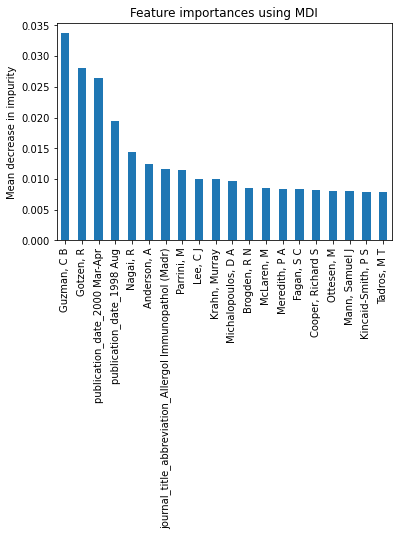


Initial number of features: 4
Number of features after removing the ones with zero importance: 4 



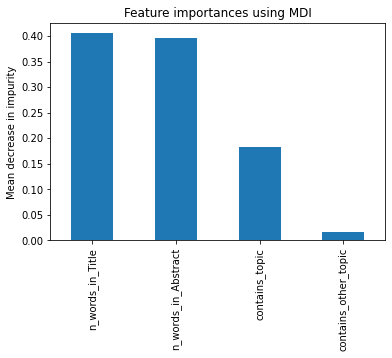


Initial number of features: 4933
Number of features after removing the ones with zero importance: 183 



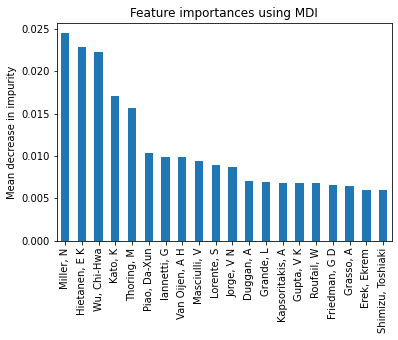

In [67]:
# creating the random forest that computes feature importance

for i in dataset:

  forest = RandomForestClassifier(random_state=0)
  forest.fit(dataset[i][dataset[i].columns.difference(["text", "text_clean", "Label"])], dataset[i]["Label"])

  #computing feature importance
  importances = forest.feature_importances_

  features = list(set(dataset[i].columns) - set(["text", "text_clean", "Label"])) #all columns except text, text_clean and Label

  forest_importances = pd.Series(importances, index=features) 
  forest_importances = forest_importances.sort_values(ascending=False)

  print("\nInitial number of features:", len(forest_importances))

  #non-important features
  non_important_features = forest_importances.where(forest_importances <= 0.002)
  non_important_features = non_important_features.dropna()

  #important features
  forest_importances = forest_importances.where(forest_importances > 0.002)
  forest_importances = forest_importances.dropna()
  print("Number of features after removing the ones with zero importance:", len(forest_importances), "\n")

  #visualization of the top 20 features sorted by importance
  fig, ax = plt.subplots()
  forest_importances.head(20).plot.bar(ax=ax)
  plt.title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  plt.show()

  #removing non important features from the dataset
  dataset[i].drop(non_important_features.index, axis = 1, inplace=True)

In [68]:
#saving the preprocessed datasets and col_names in csv files (to use them in "Dataset statistics by class")
if from_drive == True: 
  with open(path + "/preprocessed_ace2.csv", 'w', encoding = 'utf-8-sig') as f:
    dataset["ace"].to_csv(f) 
  with open(path + "/preprocessed_copd2.csv", 'w', encoding = 'utf-8-sig') as f:
    dataset["copd"].to_csv(f) 
  with open(path + "/preprocessed_ppi2.csv", 'w', encoding = 'utf-8-sig') as f:
    dataset["ppi"].to_csv(f) 
else: 
  filepath = Path('/content/preprocessed_ace2.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)  
  dataset["ace"].to_csv(filepath)
  filepath = Path('/content/preprocessed_copd2.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)  
  dataset["copd"].to_csv(filepath)
  filepath = Path('/content/preprocessed_ppi2.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)
  dataset["ppi"].to_csv(filepath)

## Models training and resuls


DATASET ace 


Split number 1 

Training matrix: (1996, 13393)
Test matrix: (500, 13393)

SVM RESULTS:


F-2 score with dataset ace : 0.40816326530612246 

F-3 score with dataset ace : 0.449438202247191 



,precision,recall,f1-score,support
0,0.992,0.974,0.983,492.000
1,0.235,0.500,0.320,8.000
accuracy,0.966,0.966,0.966,0.966
macro avg,0.614,0.737,0.651,500.000
weighted avg,0.980,0.966,0.972,500.000



DT RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.984,0.984,0.984,492.000
1,0.000,0.000,0.000,8.000
accuracy,0.968,0.968,0.968,0.968
macro avg,0.492,0.492,0.492,500.000
weighted avg,0.968,0.968,0.968,500.000



RF RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,492.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,500.000
weighted avg,0.968,0.984,0.976,500.000



Split number 2 

Training matrix: (1997, 13393)
Test matrix: (499, 13393)

SVM RESULTS:


F-2 score with dataset ace : 0.4054054054054054 

F-3 score with dataset ace : 0.41666666666666663 



,precision,recall,f1-score,support
0,0.992,0.988,0.990,492.00
1,0.333,0.429,0.375,7.00
accuracy,0.980,0.980,0.980,0.98
macro avg,0.663,0.708,0.682,499.00
weighted avg,0.983,0.980,0.981,499.00



DT RESULTS:


F-2 score with dataset ace : 0.4878048780487805 

F-3 score with dataset ace : 0.5263157894736843 



,precision,recall,f1-score,support
0,0.994,0.982,0.988,492.000
1,0.308,0.571,0.400,7.000
accuracy,0.976,0.976,0.976,0.976
macro avg,0.651,0.777,0.694,499.000
weighted avg,0.984,0.976,0.979,499.000



RF RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 3 

Training matrix: (1997, 13393)
Test matrix: (499, 13393)

SVM RESULTS:


F-2 score with dataset ace : 0.375 

F-3 score with dataset ace : 0.4 



,precision,recall,f1-score,support
0,0.992,0.982,0.987,492.000
1,0.250,0.429,0.316,7.000
accuracy,0.974,0.974,0.974,0.974
macro avg,0.621,0.705,0.651,499.000
weighted avg,0.981,0.974,0.977,499.000



DT RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.986,0.982,0.984,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.968,0.968,0.968,0.968
macro avg,0.493,0.491,0.492,499.000
weighted avg,0.972,0.968,0.970,499.000



RF RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 4 

Training matrix: (1997, 13393)
Test matrix: (499, 13393)

SVM RESULTS:


F-2 score with dataset ace : 0.375 

F-3 score with dataset ace : 0.4 



,precision,recall,f1-score,support
0,0.992,0.982,0.987,492.000
1,0.250,0.429,0.316,7.000
accuracy,0.974,0.974,0.974,0.974
macro avg,0.621,0.705,0.651,499.000
weighted avg,0.981,0.974,0.977,499.000



DT RESULTS:


F-2 score with dataset ace : 0.3947368421052631 

F-3 score with dataset ace : 0.4109589041095891 



,precision,recall,f1-score,support
0,0.992,0.986,0.989,492.000
1,0.300,0.429,0.353,7.000
accuracy,0.978,0.978,0.978,0.978
macro avg,0.646,0.707,0.671,499.000
weighted avg,0.982,0.978,0.980,499.000



RF RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 5 

Training matrix: (1997, 13393)
Test matrix: (499, 13393)

SVM RESULTS:


F-2 score with dataset ace : 0.23255813953488375 

F-3 score with dataset ace : 0.24096385542168675 



,precision,recall,f1-score,support
0,0.988,0.982,0.985,491.00
1,0.182,0.250,0.211,8.00
accuracy,0.970,0.970,0.970,0.97
macro avg,0.585,0.616,0.598,499.00
weighted avg,0.975,0.970,0.972,499.00



DT RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.984,0.992,0.988,491.000
1,0.000,0.000,0.000,8.000
accuracy,0.976,0.976,0.976,0.976
macro avg,0.492,0.496,0.494,499.000
weighted avg,0.968,0.976,0.972,499.000



RF RESULTS:


F-2 score with dataset ace : 0.0 

F-3 score with dataset ace : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,491.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,499.000
weighted avg,0.968,0.984,0.976,499.000



DATASET copd 


Split number 1 

Training matrix: (1284, 14963)
Test matrix: (322, 14963)

SVM RESULTS:


F-2 score with dataset copd : 0.663716814159292 

F-3 score with dataset copd : 0.704225352112676 



,precision,recall,f1-score,support
0,0.961,0.872,0.914,282.000
1,0.455,0.750,0.566,40.000
accuracy,0.857,0.857,0.857,0.857
macro avg,0.708,0.811,0.740,322.000
weighted avg,0.898,0.857,0.871,322.000



DT RESULTS:


F-2 score with dataset copd : 0.5445544554455446 

F-3 score with dataset copd : 0.5472636815920399 



,precision,recall,f1-score,support
0,0.936,0.929,0.932,282.000
1,0.524,0.550,0.537,40.000
accuracy,0.882,0.882,0.882,0.882
macro avg,0.730,0.740,0.734,322.000
weighted avg,0.885,0.882,0.883,322.000



RF RESULTS:


F-2 score with dataset copd : 0.37356321839080464 

F-3 score with dataset copd : 0.3475935828877006 



,precision,recall,f1-score,support
0,0.912,0.996,0.953,282.000
1,0.929,0.325,0.481,40.000
accuracy,0.913,0.913,0.913,0.913
macro avg,0.920,0.661,0.717,322.000
weighted avg,0.914,0.913,0.894,322.000



Split number 2 

Training matrix: (1285, 14963)
Test matrix: (321, 14963)

SVM RESULTS:


F-2 score with dataset copd : 0.6858407079646018 

F-3 score with dataset copd : 0.7363420427553444 



,precision,recall,f1-score,support
0,0.968,0.862,0.912,282.000
1,0.443,0.795,0.569,39.000
accuracy,0.854,0.854,0.854,0.854
macro avg,0.705,0.828,0.740,321.000
weighted avg,0.904,0.854,0.870,321.000



DT RESULTS:


F-2 score with dataset copd : 0.6783919597989949 

F-3 score with dataset copd : 0.6852791878172588 



,precision,recall,f1-score,support
0,0.957,0.943,0.950,282.000
1,0.628,0.692,0.659,39.000
accuracy,0.913,0.913,0.913,0.913
macro avg,0.792,0.818,0.804,321.000
weighted avg,0.917,0.913,0.915,321.000



RF RESULTS:


F-2 score with dataset copd : 0.2647058823529412 

F-3 score with dataset copd : 0.2465753424657534 



,precision,recall,f1-score,support
0,0.902,0.982,0.941,282.000
1,0.643,0.231,0.340,39.000
accuracy,0.891,0.891,0.891,0.891
macro avg,0.773,0.607,0.640,321.000
weighted avg,0.871,0.891,0.868,321.000



Split number 3 

Training matrix: (1285, 14963)
Test matrix: (321, 14963)

SVM RESULTS:


F-2 score with dataset copd : 0.6932773109243696 

F-3 score with dataset copd : 0.7621247113163973 



,precision,recall,f1-score,support
0,0.975,0.826,0.894,282.000
1,0.402,0.846,0.545,39.000
accuracy,0.829,0.829,0.829,0.829
macro avg,0.689,0.836,0.720,321.000
weighted avg,0.905,0.829,0.852,321.000



DT RESULTS:


F-2 score with dataset copd : 0.589622641509434 

F-3 score with dataset copd : 0.6142506142506142 



,precision,recall,f1-score,support
0,0.947,0.890,0.918,282.00
1,0.446,0.641,0.526,39.00
accuracy,0.860,0.860,0.860,0.86
macro avg,0.697,0.766,0.722,321.00
weighted avg,0.886,0.860,0.870,321.00



RF RESULTS:


F-2 score with dataset copd : 0.48022598870056493 

F-3 score with dataset copd : 0.45698924731182794 



,precision,recall,f1-score,support
0,0.927,0.986,0.955,282.000
1,0.810,0.436,0.567,39.000
accuracy,0.919,0.919,0.919,0.919
macro avg,0.868,0.711,0.761,321.000
weighted avg,0.912,0.919,0.908,321.000



Split number 4 

Training matrix: (1285, 14963)
Test matrix: (321, 14963)

SVM RESULTS:


F-2 score with dataset copd : 0.6521739130434783 

F-3 score with dataset copd : 0.7058823529411765 



,precision,recall,f1-score,support
0,0.964,0.844,0.900,282.000
1,0.405,0.769,0.531,39.000
accuracy,0.835,0.835,0.835,0.835
macro avg,0.684,0.807,0.715,321.000
weighted avg,0.896,0.835,0.855,321.000



DT RESULTS:


F-2 score with dataset copd : 0.5882352941176471 

F-3 score with dataset copd : 0.6015037593984963 



,precision,recall,f1-score,support
0,0.945,0.915,0.930,282.000
1,0.500,0.615,0.552,39.000
accuracy,0.879,0.879,0.879,0.879
macro avg,0.723,0.765,0.741,321.000
weighted avg,0.891,0.879,0.884,321.000



RF RESULTS:


F-2 score with dataset copd : 0.3801169590643275 

F-3 score with dataset copd : 0.3551912568306011 



,precision,recall,f1-score,support
0,0.915,0.993,0.952,282.000
1,0.867,0.333,0.481,39.000
accuracy,0.913,0.913,0.913,0.913
macro avg,0.891,0.663,0.717,321.000
weighted avg,0.909,0.913,0.895,321.000



Split number 5 

Training matrix: (1285, 14963)
Test matrix: (321, 14963)

SVM RESULTS:


F-2 score with dataset copd : 0.6221198156682027 

F-3 score with dataset copd : 0.6553398058252428 



,precision,recall,f1-score,support
0,0.954,0.879,0.915,282.000
1,0.443,0.692,0.540,39.000
accuracy,0.857,0.857,0.857,0.857
macro avg,0.698,0.786,0.728,321.000
weighted avg,0.892,0.857,0.870,321.000



DT RESULTS:


F-2 score with dataset copd : 0.5472636815920398 

F-3 score with dataset copd : 0.5555555555555556 



,precision,recall,f1-score,support
0,0.938,0.918,0.928,282.000
1,0.489,0.564,0.524,39.000
accuracy,0.875,0.875,0.875,0.875
macro avg,0.714,0.741,0.726,321.000
weighted avg,0.884,0.875,0.879,321.000



RF RESULTS:


F-2 score with dataset copd : 0.24096385542168672 

F-3 score with dataset copd : 0.22160664819944598 



,precision,recall,f1-score,support
0,0.900,0.993,0.944,282.000
1,0.800,0.205,0.327,39.000
accuracy,0.897,0.897,0.897,0.897
macro avg,0.850,0.599,0.635,321.000
weighted avg,0.888,0.897,0.869,321.000



DATASET ppi 


Split number 1 

Training matrix: (1061, 9104)
Test matrix: (266, 9104)

SVM RESULTS:


F-2 score with dataset ppi : 0.37735849056603776 

F-3 score with dataset ppi : 0.38834951456310685 



,precision,recall,f1-score,support
0,0.976,0.965,0.971,256.000
1,0.308,0.400,0.348,10.000
accuracy,0.944,0.944,0.944,0.944
macro avg,0.642,0.682,0.659,266.000
weighted avg,0.951,0.944,0.947,266.000



DT RESULTS:


F-2 score with dataset ppi : 0.0 

F-3 score with dataset ppi : 0.0 



,precision,recall,f1-score,support
0,0.961,0.953,0.957,256.000
1,0.000,0.000,0.000,10.000
accuracy,0.917,0.917,0.917,0.917
macro avg,0.480,0.477,0.478,266.000
weighted avg,0.925,0.917,0.921,266.000



RF RESULTS:


F-2 score with dataset ppi : 0.0 

F-3 score with dataset ppi : 0.0 



,precision,recall,f1-score,support
0,0.962,1.000,0.981,256.000
1,0.000,0.000,0.000,10.000
accuracy,0.962,0.962,0.962,0.962
macro avg,0.481,0.500,0.490,266.000
weighted avg,0.926,0.962,0.944,266.000



Split number 2 

Training matrix: (1061, 9104)
Test matrix: (266, 9104)

SVM RESULTS:


F-2 score with dataset ppi : 0.16129032258064518 

F-3 score with dataset ppi : 0.17094017094017094 



,precision,recall,f1-score,support
0,0.964,0.937,0.950,255.000
1,0.111,0.182,0.138,11.000
accuracy,0.906,0.906,0.906,0.906
macro avg,0.537,0.560,0.544,266.000
weighted avg,0.928,0.906,0.917,266.000



DT RESULTS:


F-2 score with dataset ppi : 0.39062499999999994 

F-3 score with dataset ppi : 0.4201680672268907 



,precision,recall,f1-score,support
0,0.976,0.941,0.958,255.000
1,0.250,0.455,0.323,11.000
accuracy,0.921,0.921,0.921,0.921
macro avg,0.613,0.698,0.640,266.000
weighted avg,0.946,0.921,0.932,266.000



RF RESULTS:


F-2 score with dataset ppi : 0.0 

F-3 score with dataset ppi : 0.0 



,precision,recall,f1-score,support
0,0.959,1.000,0.979,255.000
1,0.000,0.000,0.000,11.000
accuracy,0.959,0.959,0.959,0.959
macro avg,0.479,0.500,0.489,266.000
weighted avg,0.919,0.959,0.938,266.000



Split number 3 

Training matrix: (1062, 9104)
Test matrix: (265, 9104)

SVM RESULTS:


F-2 score with dataset ppi : 0.17241379310344832 

F-3 score with dataset ppi : 0.1851851851851852 



,precision,recall,f1-score,support
0,0.968,0.937,0.952,255.000
1,0.111,0.200,0.143,10.000
accuracy,0.909,0.909,0.909,0.909
macro avg,0.539,0.569,0.548,265.000
weighted avg,0.935,0.909,0.922,265.000



DT RESULTS:


F-2 score with dataset ppi : 0.2777777777777778 

F-3 score with dataset ppi : 0.2884615384615385 



,precision,recall,f1-score,support
0,0.972,0.957,0.964,255.000
1,0.214,0.300,0.250,10.000
accuracy,0.932,0.932,0.932,0.932
macro avg,0.593,0.628,0.607,265.000
weighted avg,0.944,0.932,0.937,265.000



RF RESULTS:


F-2 score with dataset ppi : 0.0 

F-3 score with dataset ppi : 0.0 



,precision,recall,f1-score,support
0,0.962,1.000,0.981,255.000
1,0.000,0.000,0.000,10.000
accuracy,0.962,0.962,0.962,0.962
macro avg,0.481,0.500,0.490,265.000
weighted avg,0.926,0.962,0.944,265.000



Split number 4 

Training matrix: (1062, 9104)
Test matrix: (265, 9104)

SVM RESULTS:


F-2 score with dataset ppi : 0.1851851851851852 

F-3 score with dataset ppi : 0.19230769230769232 



,precision,recall,f1-score,support
0,0.968,0.953,0.960,255.000
1,0.143,0.200,0.167,10.000
accuracy,0.925,0.925,0.925,0.925
macro avg,0.555,0.576,0.564,265.000
weighted avg,0.937,0.925,0.931,265.000



DT RESULTS:


F-2 score with dataset ppi : 0.2127659574468085 

F-3 score with dataset ppi : 0.20618556701030927 



,precision,recall,f1-score,support
0,0.969,0.980,0.975,255.000
1,0.286,0.200,0.235,10.000
accuracy,0.951,0.951,0.951,0.951
macro avg,0.627,0.590,0.605,265.000
weighted avg,0.943,0.951,0.947,265.000



RF RESULTS:


F-2 score with dataset ppi : 0.0 

F-3 score with dataset ppi : 0.0 



,precision,recall,f1-score,support
0,0.962,1.000,0.981,255.000
1,0.000,0.000,0.000,10.000
accuracy,0.962,0.962,0.962,0.962
macro avg,0.481,0.500,0.490,265.000
weighted avg,0.926,0.962,0.944,265.000



Split number 5 

Training matrix: (1062, 9104)
Test matrix: (265, 9104)

SVM RESULTS:


F-2 score with dataset ppi : 0.19607843137254907 

F-3 score with dataset ppi : 0.19801980198019806 



,precision,recall,f1-score,support
0,0.969,0.965,0.967,255.000
1,0.182,0.200,0.190,10.000
accuracy,0.936,0.936,0.936,0.936
macro avg,0.575,0.582,0.579,265.000
weighted avg,0.939,0.936,0.937,265.000



DT RESULTS:


F-2 score with dataset ppi : 0.3061224489795918 

F-3 score with dataset ppi : 0.30303030303030304 



,precision,recall,f1-score,support
0,0.973,0.976,0.975,255.000
1,0.333,0.300,0.316,10.000
accuracy,0.951,0.951,0.951,0.951
macro avg,0.653,0.638,0.645,265.000
weighted avg,0.949,0.951,0.950,265.000



RF RESULTS:


F-2 score with dataset ppi : 0.0 

F-3 score with dataset ppi : 0.0 



,precision,recall,f1-score,support
0,0.962,1.000,0.981,255.000
1,0.000,0.000,0.000,10.000
accuracy,0.962,0.962,0.962,0.962
macro avg,0.481,0.500,0.490,265.000
weighted avg,0.926,0.962,0.944,265.000


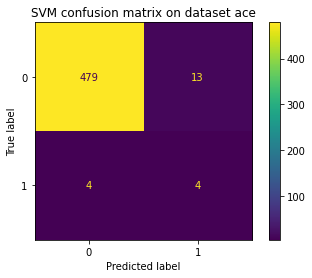

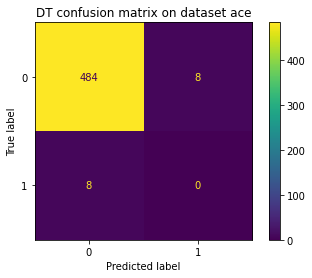

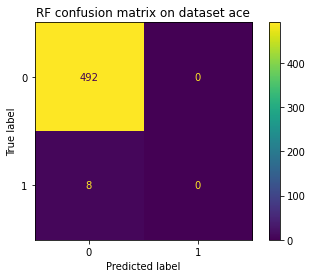

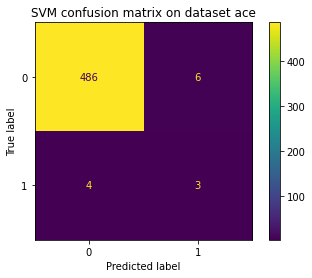

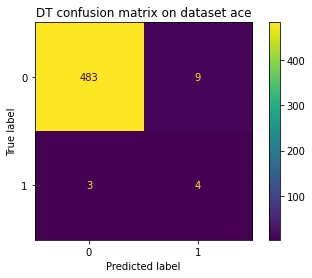

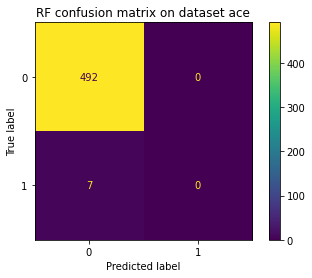

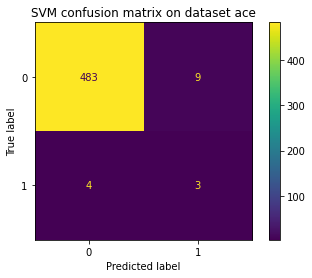

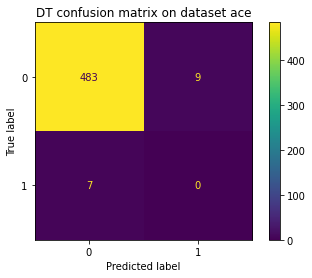

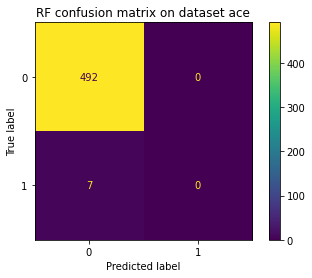

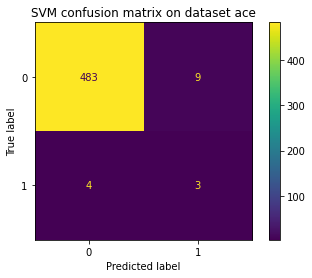

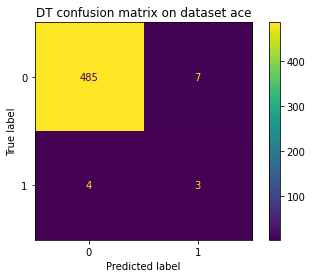

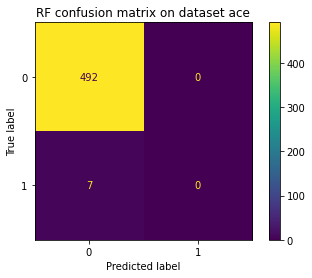

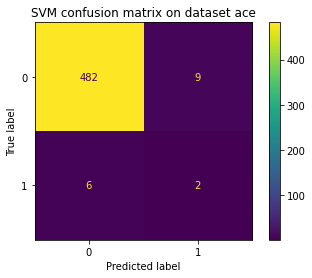

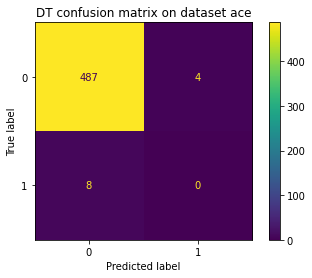

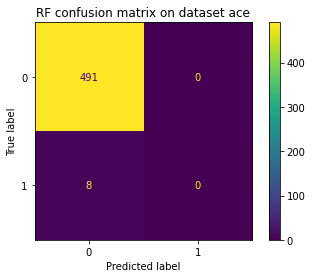

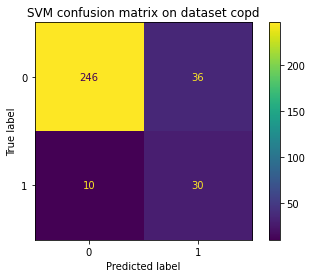

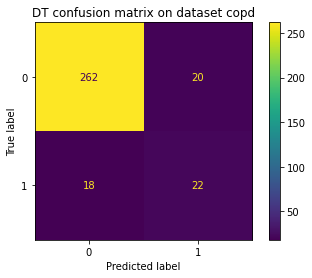

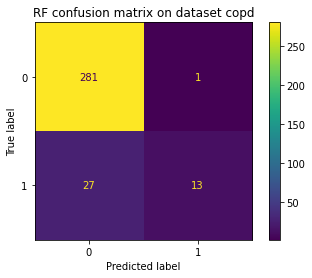

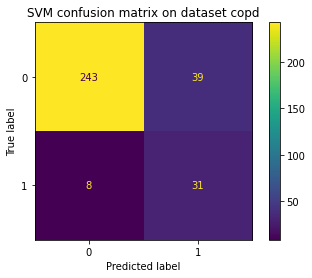

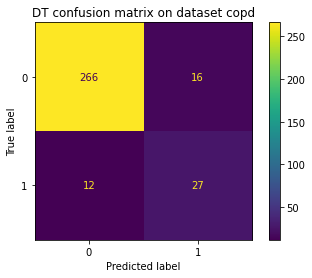

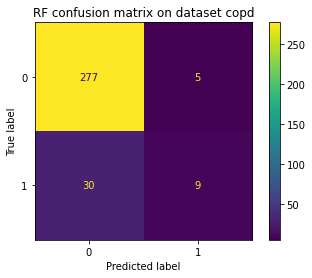

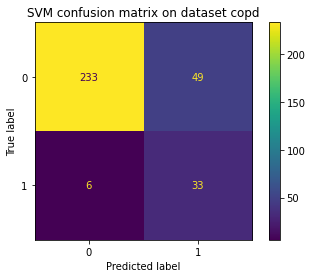

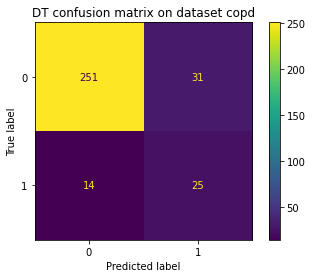

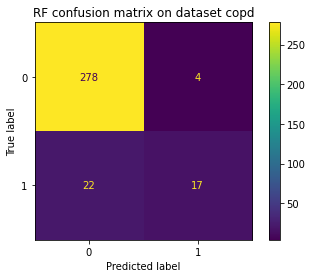

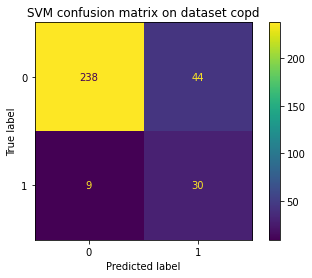

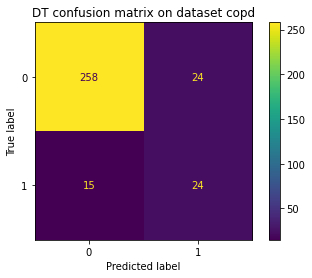

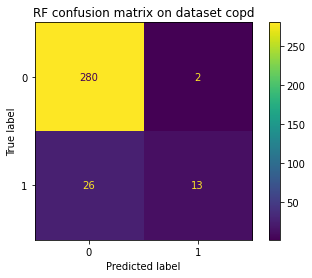

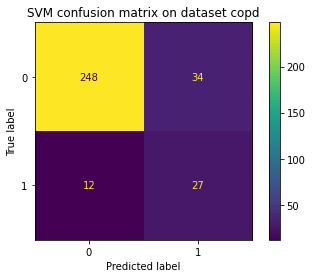

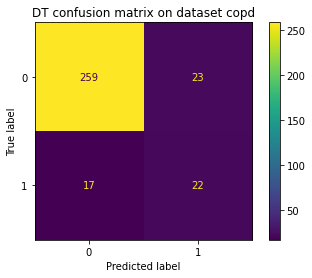

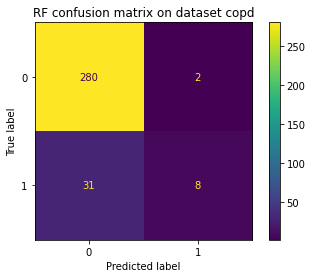

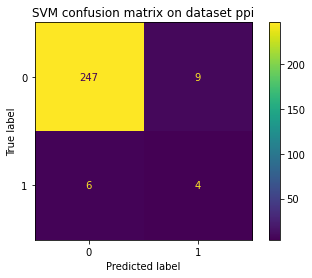

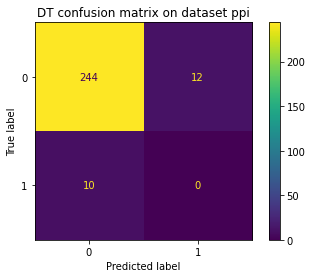

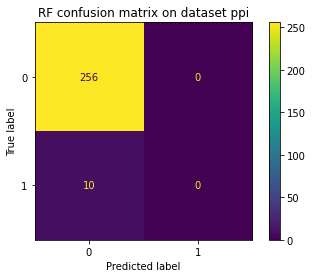

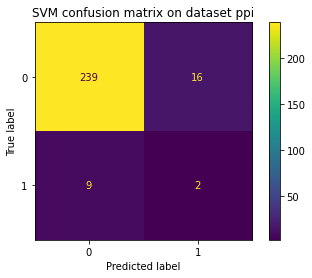

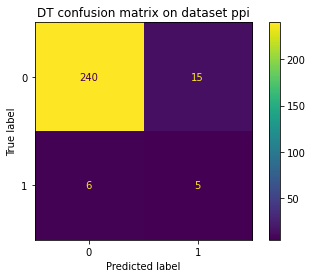

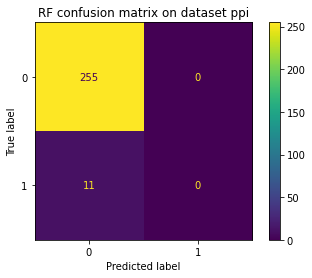

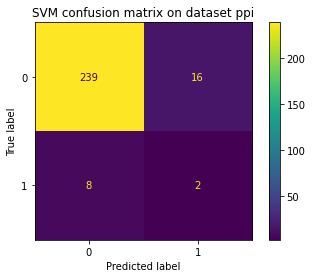

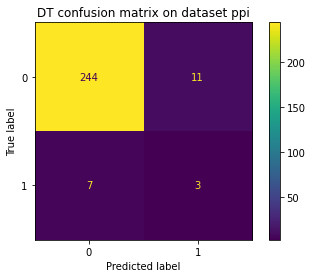

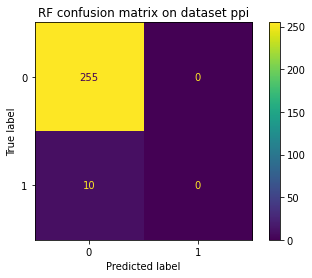

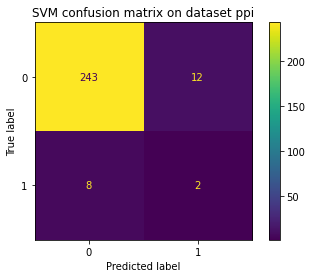

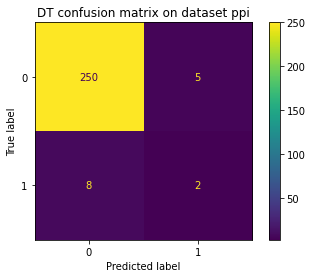

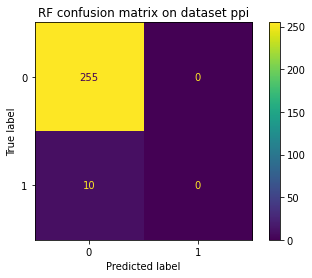

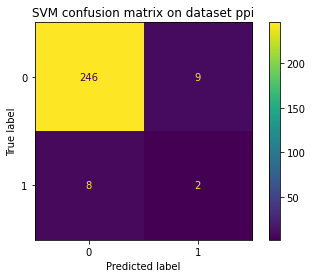

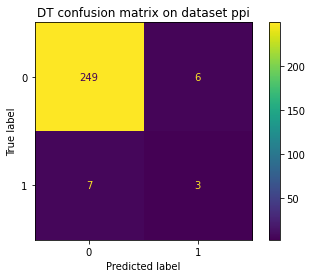

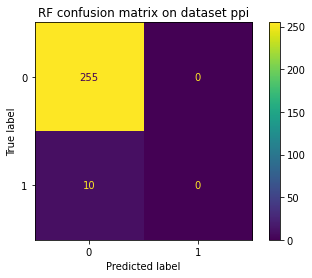

In [69]:
#creating dataset to save results
res = pd.DataFrame() 

#cross validation k=5
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

for i in dataset: 

  print("\nDATASET", i, "\n")

  X = dataset[i].loc[:, dataset[i].columns != 'Label']
  y = dataset[i]["Label"]

  j = 0

  for train_index, test_index in skf.split(X, y):

    j = j + 1
    print("\nSplit number", j, "\n")
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #resetting indexes for concat()
    X_train = X_train.reset_index(drop=True) 
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    #tf-idf
    all_text = X_train["text_clean"].values.tolist() + X_test["text_clean"].values.tolist()
    vocab = flatten_words(all_text, get_unique=True)
    tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
    training_matrix = tfidf.fit_transform(X_train["text_clean"])
    test_matrix = tfidf.fit_transform(X_test["text_clean"])

    print("Training matrix:", training_matrix.shape)
    print("Test matrix:", test_matrix.shape)

    X_train = pd.concat([X_train, pd.DataFrame(training_matrix.todense())], axis=1)
    X_test = pd.concat([X_test, pd.DataFrame(test_matrix.todense())], axis=1)


    #scaling data
    scaler = StandardScaler()
    features = list(set(X_train.columns) - set(["text", "text_clean", "Label"])) #all columns except text, text_clean and Label
    X_train = scaler.fit_transform(X_train[features].values)
    y_train = y_train.values
    X_test = scaler.transform(X_test[features].values)

    #####

    ## SVM training

    svm = LinearSVC(class_weight="balanced", random_state=1)
    svm = svm.fit(X_train, y_train)

    ## SVM results

    #prediction on the test set
    test_predicted = svm.predict(X_test) 

    #evaluation metrics
    print("\nSVM RESULTS:\n")
    new_row = {"df" : i, "train_shape" : X_train.shape, "test_shape" : X_test.shape, 
               "fold" : j, "model" : "SVM"}
    res = evalmetrics(y_test, test_predicted, svm.classes_, new_row, res)

    ######

    ## DT training

    dt = tree.DecisionTreeClassifier(class_weight="balanced", random_state=1)
    dt = dt.fit(X_train, y_train)

    ## DT results

    #prediction on the test set
    test_predicted = dt.predict(X_test)

    #evaluation metrics
    print("\nDT RESULTS:\n")
    new_row = {"df" : i, "train_shape" : X_train.shape, "test_shape" : X_test.shape, 
               "fold" : j, "model" : "DT"}
    res = evalmetrics(y_test, test_predicted, svm.classes_, new_row, res)

    ######

    # RF training

    forest = RandomForestClassifier(class_weight="balanced", random_state=1)
    forest = forest.fit(X_train, y_train)
    ## RF results

    #prediction on the test set
    test_predicted = forest.predict(X_test)

    #evaluation metrics
    print("\nRF RESULTS:\n")
    new_row = {"df" : i, "train_shape" : X_train.shape, "test_shape" : X_test.shape, 
               "fold" : j, "model" : "RF"}
    res = evalmetrics(y_test, test_predicted, svm.classes_, new_row, res)

# computation of mean metrics
res = compute_fbeta_avg(res)

In [70]:
res.head(3)

,df,train_shape,test_shape,fold,model,f2_score,f3_score,f2_avg,f3_avg
0,ace,"(1996, 13555)","(500, 13555)",1.0,SVM,0.408163,0.449438,0.359225,0.381414
1,ace,"(1996, 13555)","(500, 13555)",1.0,DT,0.000000,0.000000,0.176508,0.187455
2,ace,"(1996, 13555)","(500, 13555)",1.0,RF,0.000000,0.000000,0.000000,0.000000


In [71]:
res.shape

(45, 9)

In [72]:
#saving results in a csv file
if from_drive == True: 
  with open(path + "/out.csv", 'w', encoding = 'utf-8-sig') as f:
    res.to_csv(f)  
else: 
  filepath = Path('/content/out.csv')  
  filepath.parent.mkdir(parents=True, exist_ok=True)  
  res.to_csv(filepath)